In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
NERpath = "/shared/3/projects/benlitterer/podcastData/NER/transcripts/transcriptNEs.csv"
epNER = pd.read_csv(NERpath, sep="\t", lineterminator="\n")

In [7]:

df = pd.read_json("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthData.jsonl", orient="records", lines=True)

In [77]:
epNER.head()

,/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth/www.buzzsprout.com/3y/httpswww.buzzsprout.com7830203983942todayisyesterday.mp3MERGED,Simon Shapiro,4,17,PERSON
0,/shared/3/projects/benlitterer/podcastData/pro...,Sing Out Speak Out,30,48,WORK_OF_ART
1,/shared/3/projects/benlitterer/podcastData/pro...,many years,125,135,DATE
2,/shared/3/projects/benlitterer/podcastData/pro...,Sing Out Speak Out,362,380,WORK_OF_ART
3,/shared/3/projects/benlitterer/podcastData/pro...,Sing Out Speak Out,417,435,WORK_OF_ART
4,/shared/3/projects/benlitterer/podcastData/pro...,20,451,453,CARDINAL


In [78]:
epNER.columns = ["potentialOutPath", "ent", "start", "end", "type"]


In [79]:
epNER = epNER[epNER["type"] == "PERSON"]

In [80]:
epNER["potentialOutPath"] = "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth" +  epNER["potentialOutPath"] 

In [97]:
#epNER["potentialOutPath"] = epNER["potentialOutPath"].apply(lambda x: x[67:])

In [98]:
tempDf = pd.merge(df[["potentialOutPath", "cleanDatesLoc", "category1", "category2", "category3", "title", "epDescription"]], epNER, how="left", on="potentialOutPath")

In [161]:
peopleDf = tempDf 

In [162]:
import re

In [163]:
def containsSpecial(inStr): 
    if inStr != inStr: 
        return True
    
    if len(inStr) != len(re.sub("[^\w _]", "", inStr)): 
        return True
    return False 

peopleDf = peopleDf[peopleDf["ent"].apply(containsSpecial) == False]

peopleDf = peopleDf[peopleDf["ent"].apply(lambda x: len(x.strip().split())) == 2]

In [164]:
peopleDf.shape

(3475084, 11)

In [165]:
#consider the number Named Entities in each category 
catCounts = peopleDf[["category1", "ent", "category2" ]].groupby(["category1", "ent"]).agg(len).reset_index()

In [166]:
catList = list(pd.DataFrame(df["category1"].value_counts()).reset_index().head(7)["category1"])
topEnts = {} 
for cat in catList: 
    catDf = catCounts.loc[catCounts["category1"] == cat]
    topEnts[cat] = list(catDf.sort_values("category2", ascending=False).head(30)["ent"])


In [167]:
topEnts = pd.DataFrame(topEnts)
topEnts.to_csv("/shared/3/projects/benlitterer/podcastData/NER/transcripts/top30counts.csv", sep="\t")

In [168]:
catDf.sort_values("category2", ascending=False).head(10)["ent"]

359606      George Floyd
364615         Jiu Jitsu
373716    Michael Jordan
387581         aa marela
364212      Jesus Christ
385571      Tony Robbins
387207       Xisara Rang
384062           Tai Chi
360747      Harry Potter
365013         Joe Rogan
Name: ent, dtype: object

In [169]:
peopleDf["cleanDatesLoc"] = pd.to_datetime(peopleDf["cleanDatesLoc"])

In [170]:
peopleCounts = pd.DataFrame(peopleDf["ent"].value_counts()).reset_index()
peopleCounts.head() 

,ent,count
0,Jesus Christ,67992
1,George Floyd,32433
2,Michael Jordan,26638
3,Donald Trump,16702
4,Tom Brady,11765


In [171]:
#collective attention 
#focus on only the most interesting entities 
topEnts = ["George Floyd", "Jesus Christ", "Joe Biden", "Joe Rogan", "Donald Trump", "Micheal Jordan"]
topEntsDf = peopleDf[peopleDf["ent"].apply(lambda x: x in topEnts)]

In [172]:
groupedPeople = topEntsDf.set_index('cleanDatesLoc')[["ent", "category1", "category2"]].groupby([pd.Grouper(freq='1D'), 'category1', "ent"]).agg(len).reset_index()

In [173]:
groupedPeople.head() 

,cleanDatesLoc,category1,ent,category2
0,2020-05-11 00:00:00+00:00,arts,Donald Trump,11
1,2020-05-11 00:00:00+00:00,arts,Jesus Christ,29
2,2020-05-11 00:00:00+00:00,arts,Joe Rogan,4
3,2020-05-11 00:00:00+00:00,business,Donald Trump,33
4,2020-05-11 00:00:00+00:00,business,Jesus Christ,7


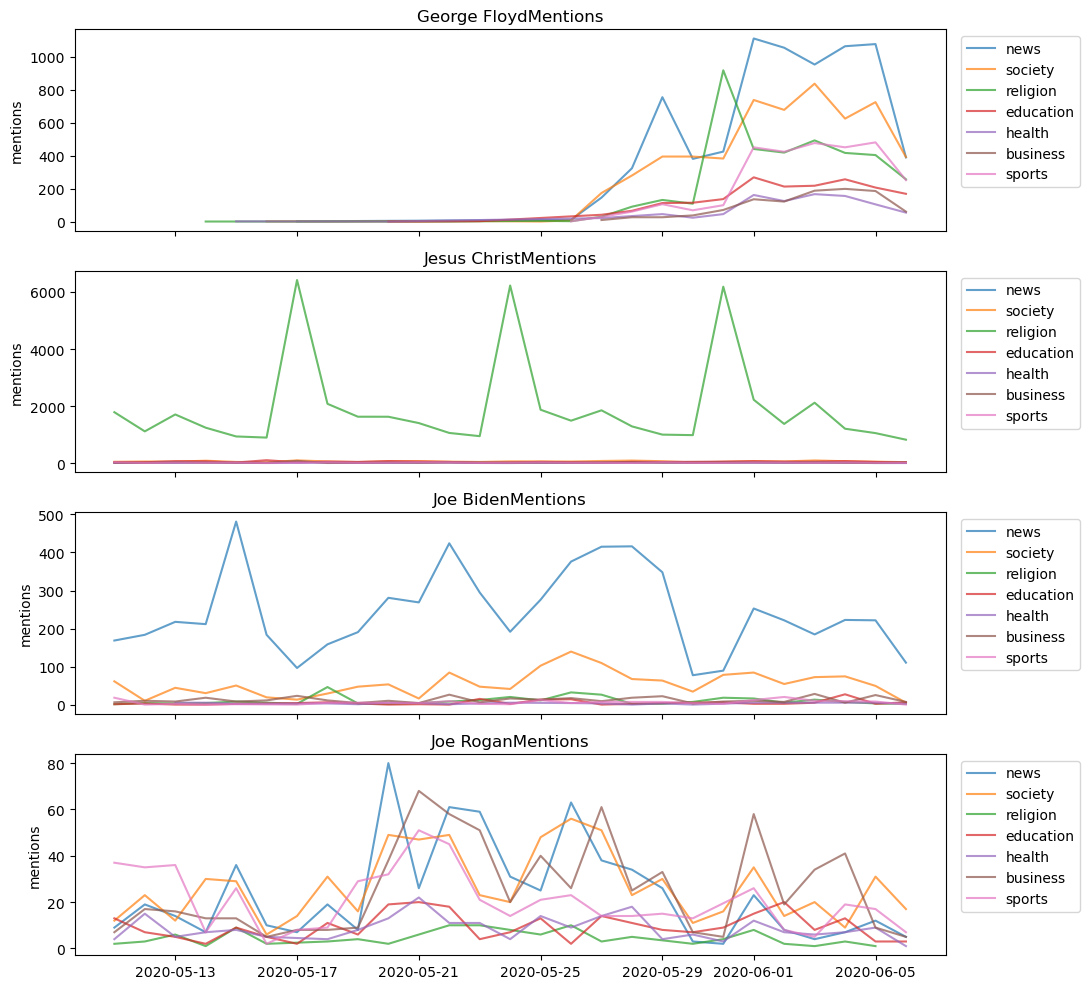

In [184]:
#look at the breakdown across categories
fig, axs = plt.subplots(4, 1, figsize=(11, 10), sharex=True)
#catLists = {"George Floyd":[["religion", "business", "society", "news", "sports"]]}

for i, currEnt in enumerate(["George Floyd", "Jesus Christ", "Joe Biden", "Joe Rogan"]): 
    selectCategories = ["news", "society", "religion", "education", "health", "business", "sports"]
    currDf = groupedPeople[(groupedPeople["ent"] == currEnt) & groupedPeople["category1"].apply(lambda x: x in selectCategories)]
    currDf = currDf[currDf["cleanDatesLoc"] < "2020-06-07"]
    sns.lineplot(currDf, x="cleanDatesLoc", y="category2", hue="category1", hue_order=selectCategories, ax=axs[i], alpha=.7)
    axs[i].set_title(currEnt + " Mentions")
    axs[i].legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    axs[i].set_xlabel(None)
    axs[i].set_ylabel("mentions")
plt.tight_layout()
plt.savefig("/home/blitt/projects/podcasts/analysis/forIC2S2/plots/NERTimeSeries.pdf")
plt.savefig("/home/blitt/projects/podcasts/analysis/forIC2S2/plots/NERTimeSeries.png", dpi=500)

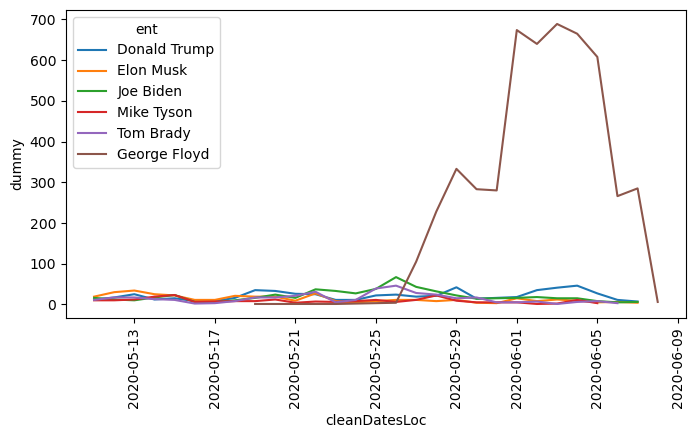

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(data=topGrouped, x="cleanDatesLoc", y="dummy", hue="ent")
#locs, labels = plt.xticks()
ax.tick_params(axis="x", rotation=90) 

In [3]:
peopleDf.head() 

NameError: name 'peopleDf' is not defined